## Pandas analysis

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a couple of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every 'x' BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [1]:
# If you didn't download it yet, please get the relevant file now!
!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ~/data/

--2021-12-14 09:36:19--  https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt
Risoluzione di www.dropbox.com (www.dropbox.com)... 162.125.69.18
Connessione a www.dropbox.com (www.dropbox.com)|162.125.69.18|:443... connesso.
Richiesta HTTP inviata, in attesa di risposta... 301 Moved Permanently
Posizione: /s/raw/xvjzaxzz3ysphme/data_000637.txt [segue]
--2021-12-14 09:36:19--  https://www.dropbox.com/s/raw/xvjzaxzz3ysphme/data_000637.txt
Riutilizzo della connessione esistente a www.dropbox.com:443.
Richiesta HTTP inviata, in attesa di risposta... 302 Found
Posizione: https://ucfd7813929f2051efc8c5296f54.dl.dropboxusercontent.com/cd/0/inline/Bb07lJcddHIwCxIVbKgllrmwd2a_w0L1iU74I3wOTxvDcV9NNHg3IySUE_XiiH6YT9RaeavJoCoheOn3qNJeZtNZmaTRqzBxS37M8MHnst8u_UyNL3hRhl5P-GPDYwMSbIL-jikb5NgB6EwN37LsjWHZ/file# [segue]
--2021-12-14 09:36:20--  https://ucfd7813929f2051efc8c5296f54.dl.dropboxusercontent.com/cd/0/inline/Bb07lJcddHIwCxIVbKgllrmwd2a_w0L1iU74I3wOTxvDcV9NNHg3IySUE_XiiH6YT9RaeavJoCoheOn3q

1\. Create a Pandas DataFrame reading N rows of the 'data_000637.txt' dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k.

2\. Find out the number of BX in a ORBIT (the value 'x').

3\. Find out how much the data taking lasted. You can either make an estimate based on the fraction of the measurements (rows) you read, or perform this check precisely by reading out the whole dataset.

4\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information).

5\. Replace the values (all 1) of the HEAD column randomly with 0 or 1.

6\. Create a new DataFrame that contains only the rows with HEAD=1.

7\. Make two occupancy plots (one for each FPGA), i.e. plot the number of counts per TDC channel

8\. Use the groupby method to find out the noisy channels, i.e. the TDC channels with most counts (say the top 3)

9\. Count the number of unique orbits. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139

In [2]:
import pandas as pd
import numpy as np

df=pd.read_csv('~/data/data_000637.txt')
df.head()
df.sort_values(['ORBIT_CNT','BX_COUNTER','TDC_MEAS'],ascending=(True,True,True))

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,1,0,64,3869200167,2760,25
...,...,...,...,...,...,...
1310715,1,0,62,3869211171,762,14
1310719,1,0,61,3869211171,762,18
1310716,1,1,4,3869211171,763,11
1310717,1,0,64,3869211171,764,0


In [3]:
print('TDC_MEAS max:',df['TDC_MEAS'].max())
print('BX_COUNTER max:',df['BX_COUNTER'].max(),'\n')

print(df.groupby('BX_COUNTER').count(),'\n')
#as we can see, the BX_COUNTER values are distributed in a quite uniform way.
#due to this we can say that the BX number in a ORBIT is the max value of BX_COUNTER +1.

print('BX in a ORBIT:',df['BX_COUNTER'].max()+1)

TDC_MEAS max: 29
BX_COUNTER max: 3563 

            HEAD  FPGA  TDC_CHANNEL  ORBIT_CNT  TDC_MEAS
BX_COUNTER                                              
0            354   354          354        354       354
1            355   355          355        355       355
2            345   345          345        345       345
3            340   340          340        340       340
4            363   363          363        363       363
...          ...   ...          ...        ...       ...
3559         329   329          329        329       329
3560         330   330          330        330       330
3561         385   385          385        385       385
3562         328   328          328        328       328
3563         351   351          351        351       351

[3564 rows x 5 columns] 

BX in a ORBIT: 3564


In [4]:
def time(orb_min,orb_max,bx):
    d=orb_max-orb_min
    u=bx*25*pow(10,-9)
    return u*d

print('Mesurament time (manual):',time(df['ORBIT_CNT'].min(),df['ORBIT_CNT'].max(),df['BX_COUNTER'].max()+1),'s')

Mesurament time (manual): 0.9804564000000001 s


In [5]:
df['Time (ns)']=((df['TDC_MEAS']*(1/30))+df['BX_COUNTER']+(df['ORBIT_CNT']*3564)*25)
print('Mesurament time (pandas):',(df['Time (ns)'].max()-df['Time (ns)'].min())*pow(10,-9),'s')
df

Mesurament time (pandas): 0.980454794125 s


,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,Time (ns)
0,1,0,123,3869200167,2374,26,3.447457e+14
1,1,0,124,3869200167,2374,27,3.447457e+14
2,1,0,63,3869200167,2553,28,3.447457e+14
3,1,0,64,3869200167,2558,19,3.447457e+14
4,1,0,64,3869200167,2760,25,3.447457e+14
...,...,...,...,...,...,...,...
1310715,1,0,62,3869211171,762,14,3.447467e+14
1310716,1,1,4,3869211171,763,11,3.447467e+14
1310717,1,0,64,3869211171,764,0,3.447467e+14
1310718,1,0,139,3869211171,769,0,3.447467e+14


In [6]:
df['HEAD']=np.random.randint(2,size=len(df['HEAD'])).copy()
df

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,Time (ns)
0,0,0,123,3869200167,2374,26,3.447457e+14
1,0,0,124,3869200167,2374,27,3.447457e+14
2,1,0,63,3869200167,2553,28,3.447457e+14
3,1,0,64,3869200167,2558,19,3.447457e+14
4,1,0,64,3869200167,2760,25,3.447457e+14
...,...,...,...,...,...,...,...
1310715,0,0,62,3869211171,762,14,3.447467e+14
1310716,0,1,4,3869211171,763,11,3.447467e+14
1310717,1,0,64,3869211171,764,0,3.447467e+14
1310718,0,0,139,3869211171,769,0,3.447467e+14


In [7]:
df1=df.loc[df['HEAD']==1].copy()
df1

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,Time (ns)
2,1,0,63,3869200167,2553,28,3.447457e+14
3,1,0,64,3869200167,2558,19,3.447457e+14
4,1,0,64,3869200167,2760,25,3.447457e+14
6,1,0,61,3869200167,2772,14,3.447457e+14
10,1,1,7,3869200167,2785,4,3.447457e+14
...,...,...,...,...,...,...,...
1310709,1,1,38,3869211171,417,8,3.447467e+14
1310710,1,1,36,3869211171,427,13,3.447467e+14
1310714,1,0,60,3869211171,762,2,3.447467e+14
1310717,1,0,64,3869211171,764,0,3.447467e+14


In [8]:
import matplotlib.pyplot as plt

df_FPGA0=df.loc[df['FPGA']==0].copy()
df_FPGA1=df.loc[df['FPGA']==1].copy()

<IPython.core.display.Javascript object>


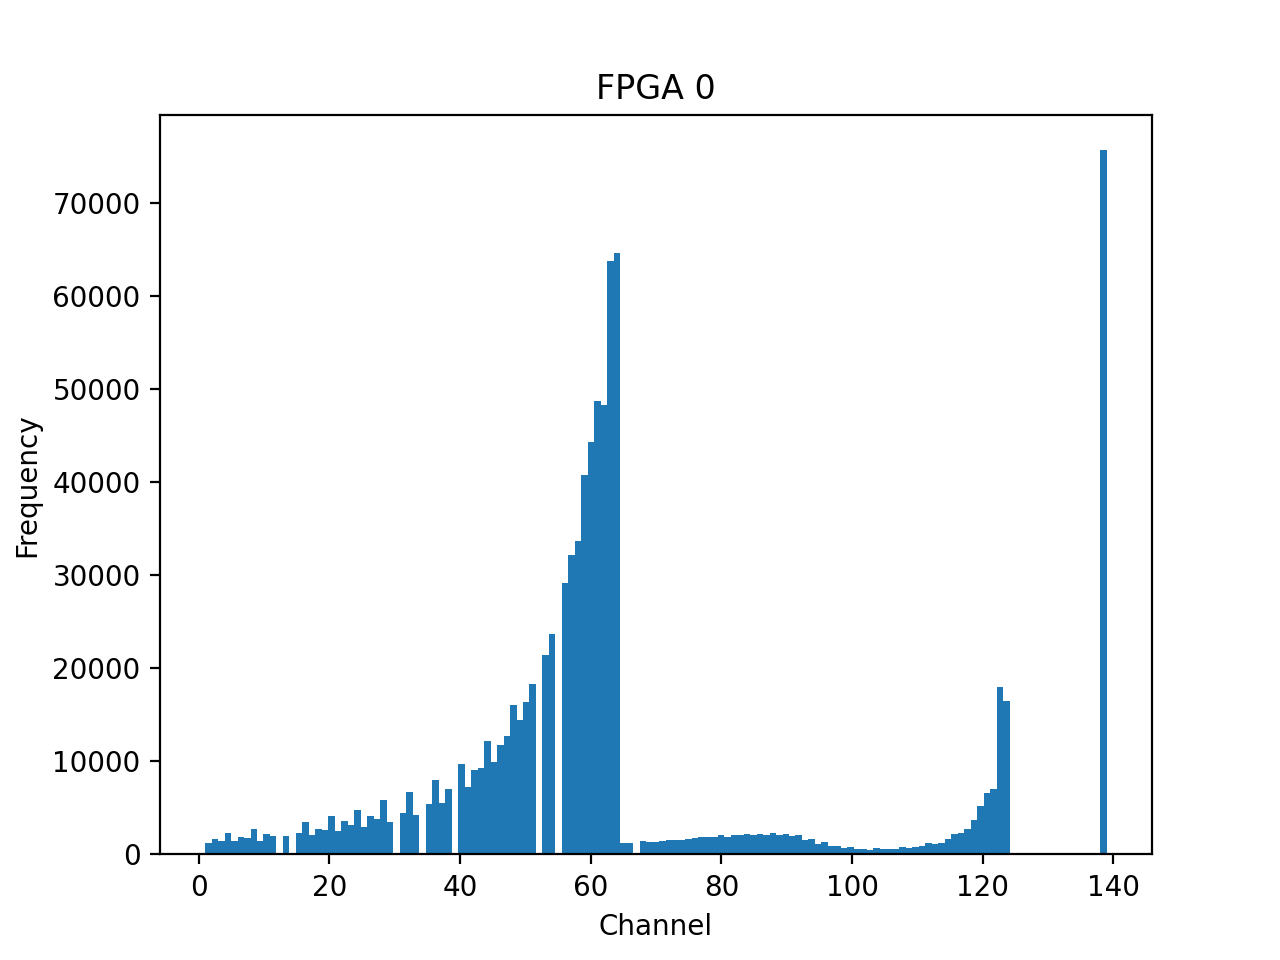

In [18]:
%matplotlib notebook
fig=plt.figure()
df_FPGA0['TDC_CHANNEL'].plot(kind='hist',bins=df_FPGA1['TDC_CHANNEL'].max())
plt.xlabel('Channel')
plt.title('FPGA 0')
plt.show()

<IPython.core.display.Javascript object>


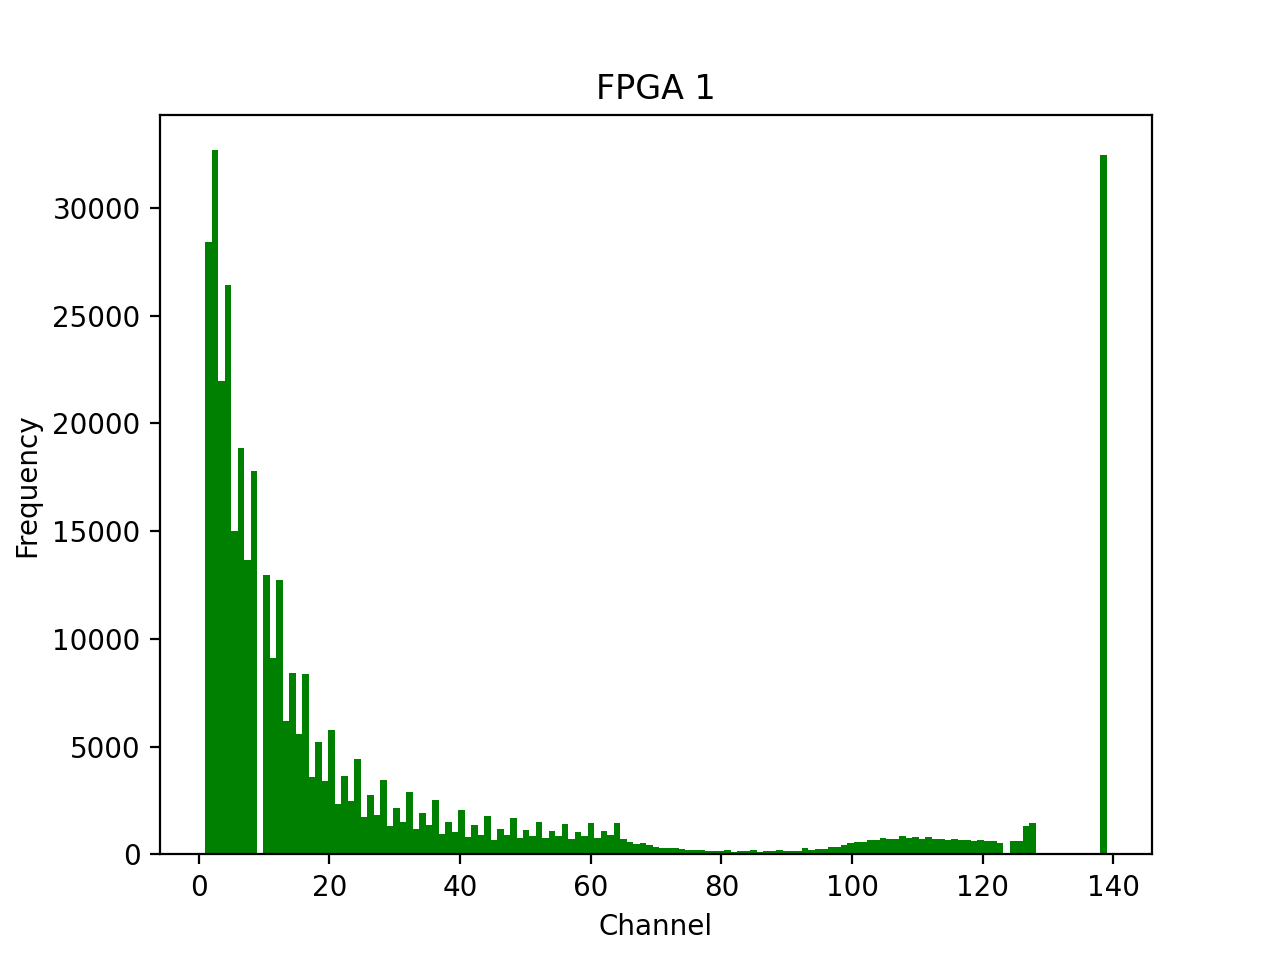

In [17]:
%matplotlib notebook
fig=plt.figure()
df_FPGA1['TDC_CHANNEL'].plot(kind='hist',bins=df_FPGA1['TDC_CHANNEL'].max(),color='green')
plt.xlabel('Channel')
plt.title('FPGA 1')
plt.show()

In [11]:
print(df.groupby('TDC_CHANNEL').max())
df.loc[df['TDC_CHANNEL']==139].head(3)

             HEAD  FPGA   ORBIT_CNT  BX_COUNTER  TDC_MEAS     Time (ns)
TDC_CHANNEL                                                            
1               1     1  3869211170        3563        29  3.447467e+14
2               1     1  3869211170        3563        29  3.447467e+14
3               1     1  3869211168        3563        29  3.447467e+14
4               1     1  3869211171        3563        29  3.447467e+14
5               1     1  3869211170        3563        29  3.447467e+14
...           ...   ...         ...         ...       ...           ...
129             1     1  3869211154        3540        28  3.447467e+14
130             1     1  3869211157        3535        29  3.447467e+14
137             1     1  3869211154        3535        15  3.447467e+14
138             1     1  3869211154        3535         9  3.447467e+14
139             1     1  3869211171        3563         0  3.447467e+14

[133 rows x 6 columns]


,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,Time (ns)
7,0,0,139,3869200167,2776,0,3.447457e+14
15,1,1,139,3869200167,2797,0,3.447457e+14
30,1,0,139,3869200167,3085,0,3.447457e+14


In [12]:
df_TDC139=df.loc[df['TDC_CHANNEL']==139]
print('Unique orbits with at least one measurement from TDC_CHANNEL=139:',df_TDC139['ORBIT_CNT'].nunique())

Unique orbits with at least one measurement from TDC_CHANNEL=139: 10976
